In [3]:
import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression



In [23]:
from sklearn.decomposition import NMF
from sklearn.preprocessing import MinMaxScaler
import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')


In [40]:
class LinearDiffusion:
    def __init__(self, image_size=28, latent_size=12):
        self.image_size = image_size
        self.latent_size = latent_size
        self._fit = False

    def _build_image_encoder(self):
        self.image_encoder = Pipeline([
            ('scaler', StandardScaler()),
            ('PCA', PCA(n_components=self.latent_size * self.latent_size))
        ])

    def _build_text_encoder(self):
        self.text_encoder = OneHotEncoder(
            categories='auto', drop='first', sparse_output=False, handle_unknown='error'
        )

    def _create_interaction_terms(self, text_embeddings, image_embeddings):
        interactions = []
        for i in range(text_embeddings.shape[1]):
            interactions.append(image_embeddings * np.array([text_embeddings[:, i]]).T)
        return np.concatenate(interactions, axis=1)

    def _create_features_noise(self, text_embeddings, image_embeddings=None, std=1.0, seed=1337):
        rng = np.random.default_rng(seed)
        noise = rng.normal(loc=0.0, scale=std, size=(text_embeddings.shape[0], self.latent_size * self.latent_size))
        if image_embeddings is not None:
            noised_embeddings = image_embeddings + noise
        else:
            noised_embeddings = noise
        interaction_terms = self._create_interaction_terms(text_embeddings, noised_embeddings)
        features = np.concatenate([noised_embeddings, text_embeddings, interaction_terms], axis=1)
        return features, noise

    def fit(self, X, y):
        self._build_image_encoder()
        self._build_text_encoder()
        images_flat = y.reshape(y.shape[0], self.image_size * self.image_size)
        images_encoded = self.image_encoder.fit_transform(images_flat)
        labels = np.array(X).reshape(-1, 1)
        label_embeddings = self.text_encoder.fit_transform(labels)
        X_train, y_noise = self._create_features_noise(label_embeddings, images_encoded)
        self.model = LinearRegression().fit(X_train, y_noise)
        self._fit = True
        return self

    def predict(self, X, seed=1337):
        assert self._fit, "Please fit the model before running predict"
        labels = np.array(X).reshape(-1, 1)
        label_embeddings = self.text_encoder.transform(labels)
        X_test, noise_test = self._create_features_noise(label_embeddings, seed=seed)
        est_noise = self.model.predict(X_test)
        denoised = noise_test - est_noise
        est_imgs = self.image_encoder.inverse_transform(denoised).reshape(label_embeddings.shape[0], self.image_size, self.image_size)
        return est_imgs
        
class LinearDiffusion_NMF:
    def __init__(self, image_size=28, latent_size=12):
        self.image_size = image_size
        self.latent_size = latent_size
        self._fit = False
        logging.info("Initialized LinearDiffusion_NMF with image size {} and latent size {}".format(image_size, latent_size))

    def _build_image_encoder(self):
        logging.info("Building image encoder pipeline")
        self.image_encoder = Pipeline([
            ('scaler', MinMaxScaler()),
            ('NMF', NMF(n_components=self.latent_size * self.latent_size, init='random', random_state=42))
        ])
        logging.info("Image encoder pipeline built successfully")

    def _build_text_encoder(self):
        logging.info("Building text encoder")
        self.text_encoder = OneHotEncoder(
            categories='auto', drop='first', sparse_output=False, handle_unknown='error'
        )
        logging.info("Text encoder built successfully")

    def _create_interaction_terms(self, text_embeddings, image_embeddings):
        logging.info("Creating interaction terms")
        interactions = []
        for i in range(text_embeddings.shape[1]):
            interactions.append(image_embeddings * np.array([text_embeddings[:, i]]).T)
        result = np.concatenate(interactions, axis=1)
        logging.info("Interaction terms created")
        return result

    def _create_features_noise(self, text_embeddings, image_embeddings=None, std=1.0, seed=1337):
        logging.info("Creating features and adding noise")
        rng = np.random.default_rng(seed)
        noise = rng.normal(loc=0.0, scale=std, size=(text_embeddings.shape[0], self.latent_size * self.latent_size))
        if image_embeddings is not None:
            noised_embeddings = image_embeddings + noise
        else:
            noised_embeddings = noise
        interaction_terms = self._create_interaction_terms(text_embeddings, noised_embeddings)
        features = np.concatenate([noised_embeddings, text_embeddings, interaction_terms], axis=1)
        logging.info("Features and noise created")
        return features, noise

    def fit(self, X, y):
        logging.info("Fitting model")
        self._build_image_encoder()
        self._build_text_encoder()
        images_flat = y.reshape(y.shape[0], self.image_size * self.image_size)
        images_encoded = self.image_encoder.fit_transform(images_flat)
        labels = np.array(X).reshape(-1, 1)
        label_embeddings = self.text_encoder.fit_transform(labels)
        X_train, y_noise = self._create_features_noise(label_embeddings, images_encoded)
        self.model = LinearRegression().fit(X_train, y_noise)
        self._fit = True
        logging.info("Model fitted successfully")
        return self

    def predict(self, X, seed=1337):
        logging.info("Predicting")
        assert self._fit, "Please fit the model before running predict"
        labels = np.array(X).reshape(-1, 1)
        label_embeddings = self.text_encoder.transform(labels)
        X_test, noise_test = self._create_features_noise(label_embeddings, seed=seed)
        est_noise = self.model.predict(X_test)
        denoised = noise_test - est_noise
        est_imgs = self.image_encoder.inverse_transform(denoised).reshape(label_embeddings.shape[0], self.image_size, self.image_size)
        logging.info("Prediction completed")
        return est_imgs


In [41]:
from keras.datasets import mnist

In [42]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()
# setup the training data
train_imgs = train_X
test_imgs = test_X
all_imgs = np.concatenate([train_imgs, test_imgs])

all_labels = [str(val) for val in np.concatenate([train_y, test_y])]

ld = LinearDiffusion_NMF()
ld.fit(all_labels, all_imgs)

2024-05-11 10:31:57,818 - INFO - Initialized LinearDiffusion_NMF with image size 28 and latent size 12
2024-05-11 10:31:57,818 - INFO - Fitting model
2024-05-11 10:31:57,819 - INFO - Building image encoder pipeline
2024-05-11 10:31:57,819 - INFO - Image encoder pipeline built successfully
2024-05-11 10:31:57,819 - INFO - Building text encoder
2024-05-11 10:31:57,820 - INFO - Text encoder built successfully
c:\Users\noahk\AppData\Local\pypoetry\Cache\virtualenvs\linear-diffusion-u4o1WNMP-py3.11\Lib\site-packages\sklearn\decomposition\_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
2024-05-11 10:37:02,410 - INFO - Creating features and adding noise
2024-05-11 10:37:02,543 - INFO - Creating interaction terms
2024-05-11 10:37:02,938 - INFO - Interaction terms created
2024-05-11 10:37:03,202 - INFO - Features and noise created
2024-05-11 10:37:12,226 - INFO - Model fitted successfully


2024-05-11 10:00:46,903 - INFO - Predicting
2024-05-11 10:00:46,904 - INFO - Creating features and adding noise
2024-05-11 10:00:46,905 - INFO - Creating interaction terms
2024-05-11 10:00:46,905 - INFO - Interaction terms created
2024-05-11 10:00:46,905 - INFO - Features and noise created
2024-05-11 10:00:46,908 - INFO - Prediction completed


Text(0.5, 0.98, 'Images Generated from Prompt')

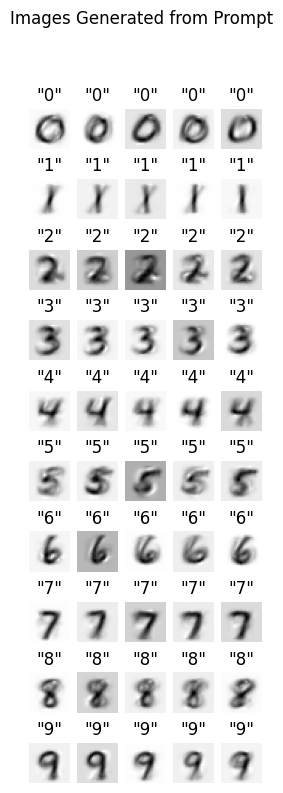

In [26]:
import matplotlib.pyplot as plt
from itertools import chain

rows=10
cols=5
fig, ax = plt.subplots(rows,cols,facecolor='white', figsize=(3,9))

test_labels = list(chain.from_iterable([[str(i)]*5 for i in range(10)]))

# here's our prediction!
test_images = ld.predict(test_labels,seed=137)

for i in range(rows*cols):
    ax[i//cols][i%cols].imshow(test_images[i],
          cmap='gray_r')
    ax[i//cols][i%cols].axis('off')
    ax[i//cols][i%cols].set_title(f"\"{test_labels[i]}\"")
fig.suptitle("Images Generated from Prompt")

Text(0.5, 0.98, 'Images Generated from Prompt')

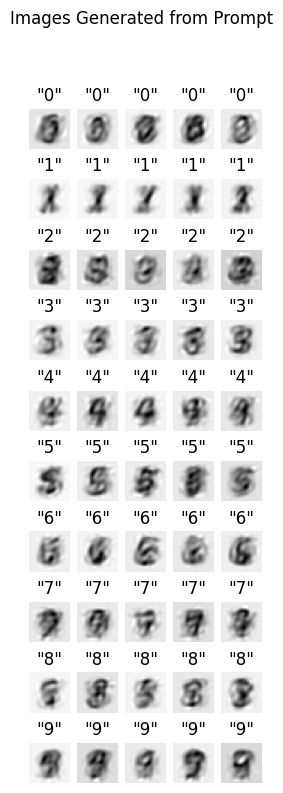

In [18]:
import matplotlib.pyplot as plt
from itertools import chain

rows=10
cols=5
fig, ax = plt.subplots(rows,cols,facecolor='white', figsize=(3,9))

test_labels = list(chain.from_iterable([[str(i)]*5 for i in range(10)]))

# here's our prediction!
test_images = ld.predict(test_labels,seed=137)

for i in range(rows*cols):
    ax[i//cols][i%cols].imshow(test_images[i],
          cmap='gray_r')
    ax[i//cols][i%cols].axis('off')
    ax[i//cols][i%cols].set_title(f"\"{test_labels[i]}\"")
fig.suptitle("Images Generated from Prompt")

Investigation

In [119]:
import logging
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.decomposition import NMF
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

def build_image_encoder(latent_size, image_size):
    """
    Build an image encoder pipeline that scales the image data and then applies Non-negative Matrix Factorization (NMF)
    to reduce the dimensionality to the latent size squared.
    
    Args:
        latent_size (int): The size of the latent space.
        image_size (int): The size of the images (assumed to be square).
    
    Returns:
        Pipeline: An sklearn pipeline that scales and applies NMF.
    """
    logging.info("Building image encoder pipeline")
    encoder = Pipeline([
        ('scaler', MinMaxScaler()),
        ('NMF', NMF(n_components=latent_size**2, init='random', random_state=42))
    ])
    return encoder

def build_text_encoder():
    """
    Build a text encoder using one-hot encoding.
    
    Returns:
        OneHotEncoder: An sklearn OneHotEncoder for text data.
    """
    logging.info("Building text encoder")
    encoder = OneHotEncoder(categories='auto', drop='first', sparse_output=False, handle_unknown='error')
    return encoder

def create_interaction_terms(text_embeddings, image_embeddings):
    """
    Create interaction terms by multiplying each text embedding with the entire image embedding.
    
    Args:
        text_embeddings (ndarray): The one-hot encoded text data.
        image_embeddings (ndarray): The encoded image data.
    
    Returns:
        ndarray: Concatenated interaction terms.
    """
    logging.info("Creating interaction terms")
    interactions = [image_embeddings * text_embeddings[:, i].reshape(-1, 1) for i in range(text_embeddings.shape[1])]
    return np.concatenate(interactions, axis=1)

def create_features_noise(text_embeddings, image_embeddings=None, std=1.0, seed=1337,latent_size=12):
    """
    Create features by adding Gaussian noise to the image embeddings and generating interaction terms.
    
    Args:
        text_embeddings (ndarray): The one-hot encoded text data.
        image_embeddings (ndarray): The encoded image data.
        std (float): Standard deviation of the Gaussian noise.
        seed (int): Random seed for reproducibility.
    
    Returns:
        tuple: Concatenated features and the added noise.
    """
    logging.info("Creating features and adding noise")
    rng = np.random.default_rng(seed)
    noise = rng.normal(loc=0.0, scale=std, size=(text_embeddings.shape[0], latent_size**2))
    if image_embeddings is not None:
        noised_embeddings = image_embeddings + noise
    else:
        noised_embeddings = noise
    
    interaction_terms = create_interaction_terms(text_embeddings, noised_embeddings)
    features = np.concatenate([noised_embeddings, text_embeddings, interaction_terms], axis=1)
    return features, noise

def fit_model(image_encoder, text_encoder, X_text, X_images, image_size):
    """
    Fit a linear regression model to predict noise in image embeddings.
    
    Args:
        image_encoder (Pipeline): The image encoder pipeline.
        text_encoder (OneHotEncoder): The text encoder.
        X_text (list): List of text labels.
        X_images (ndarray): Array of images.
        image_size (int): The size of the images (assumed to be square).
    
    Returns:
        tuple: The fitted model, image encoder, and text encoder.
    """
    logging.info("Starting the model fitting process")
    logging.info("Reshaping the images")
    images_flat = X_images.reshape(X_images.shape[0], image_size**2)
    logging.info(f"Images reshaped to {images_flat.shape}")

    logging.info("Encoding the images and text")
    images_encoded = image_encoder.fit_transform(images_flat)
    logging.info(f"Data encoded to {images_encoded.shape}")


    logging.info("Fitting the text encoder")
    label_embeddings = text_encoder.fit_transform(np.array(X_text).reshape(-1, 1))
    logging.info(f"Text encoder fitted to {label_embeddings.shape}")


    logging.info("Creating features and adding noise")
    X_train, y_noise = create_features_noise(label_embeddings, images_encoded)
    logging.info(f"Features created with shape {X_train.shape}")


    logging.info("Fitting the linear regression model")
    model = LinearRegression().fit(X_train, y_noise)
    logging.info("Model fitted successfully")
    return model, image_encoder, text_encoder

def predict(model, image_encoder, text_encoder, X_text, seed=1337, image_size=28):
    """
    Predict denoised image embeddings and reconstruct the images.
    
    Args:
        model (LinearRegression): The fitted linear regression model.
        image_encoder (Pipeline): The image encoder pipeline.
        text_encoder (OneHotEncoder): The text encoder.
        X_text (list): List of text labels for prediction.
        seed (int): Random seed for reproducibility.
        image_size (int): The size of the images (assumed to be square).
    
    Returns:
        ndarray: Reconstructed images.
    """
    logging.info("Predicting")
    label_embeddings = text_encoder.transform(np.array(X_text).reshape(-1, 1))
    X_test, noise_test = create_features_noise(label_embeddings, seed=seed)
    est_noise = model.predict(X_test)
    denoised = noise_test - est_noise
    est_imgs = image_encoder.inverse_transform(denoised).reshape(-1, image_size, image_size)
    return est_imgs

def plot_images(images, titles, n=10):
    """
    Plot a given number of images with titles.
    
    Args:
        images (ndarray): Array of images to plot.
        titles (list): List of titles for the images.
        n (int): Number of images to plot.
    """
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(2, n//2, i+1)
        plt.imshow(images[i], cmap='gray')
        plt.title(titles[i])
        plt.axis('off')
    plt.show()

def plot_nmf_components(components, image_size, latent_size,sample_size=5):
    """
    Plot the components of the NMF model.
    
    Args:
        components (ndarray): The components from the NMF model.
        image_size (int): The size of the images (assumed to be square).
        latent_size (int): The size of the latent space.
    """
    n_components = components.shape[0]
    fig, axes = plt.subplots(nrows=sample_size, ncols=sample_size, figsize=(15, 15))
    fig.subplots_adjust(hspace=0.1, wspace=0.1)
    for i, ax in enumerate(axes.flat[:sample_size**2]):
        if i < n_components:
            # Plot the i-th component
            ax.imshow(components[i].reshape(image_size, image_size), cmap='gray')
            ax.set_xticks([])
            ax.set_yticks([])
        else:
            ax.axis('off')
    plt.show()


2024-05-14 07:35:37,331 - INFO - Building image encoder pipeline
2024-05-14 07:35:37,331 - INFO - Building text encoder
2024-05-14 07:35:37,332 - INFO - Original images


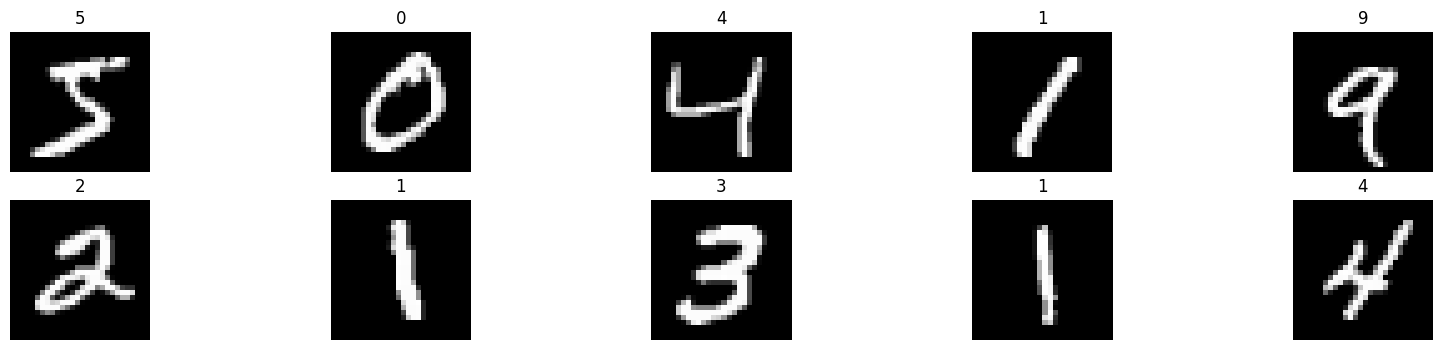

2024-05-14 07:35:37,593 - INFO - Fitting the model with training data
2024-05-14 07:35:37,593 - INFO - Fitting model
c:\Users\noahk\AppData\Local\pypoetry\Cache\virtualenvs\linear-diffusion-u4o1WNMP-py3.11\Lib\site-packages\sklearn\decomposition\_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
2024-05-14 07:40:23,107 - INFO - Creating features and adding noise
2024-05-14 07:40:23,228 - INFO - Creating interaction terms
2024-05-14 07:40:36,842 - INFO - Encoded images after image encoder transformation


In [98]:
import numpy as np
from tensorflow.keras.datasets import mnist

# Initial setup and data loading
latent_size = 12
image_size = 28
(train_X, train_y), (test_X, test_y) = mnist.load_data()

train_labels = [str(val) for val in train_y]

# Build encoders
image_encoder = build_image_encoder(latent_size, image_size)
text_encoder = build_text_encoder()

# Visualize original images
logging.info("Original images")
plot_images(train_X, train_labels, n=10)

# Fit the model with detailed logging and outputs
logging.info("Fitting the model with training data")
model, fitted_image_encoder, fitted_text_encoder = fit_model(image_encoder, text_encoder, train_labels, train_X, image_size)

# Encoded images
logging.info("Encoded images after image encoder transformation")
# Use the updated visualization function
images_flat = train_X.reshape(train_X.shape[0], image_size**2)
images_encoded = image_encoder.transform(images_flat)
components = image_encoder.named_steps['NMF'].components_


2024-05-14 07:43:29,854 - INFO - Visualizing NMF components


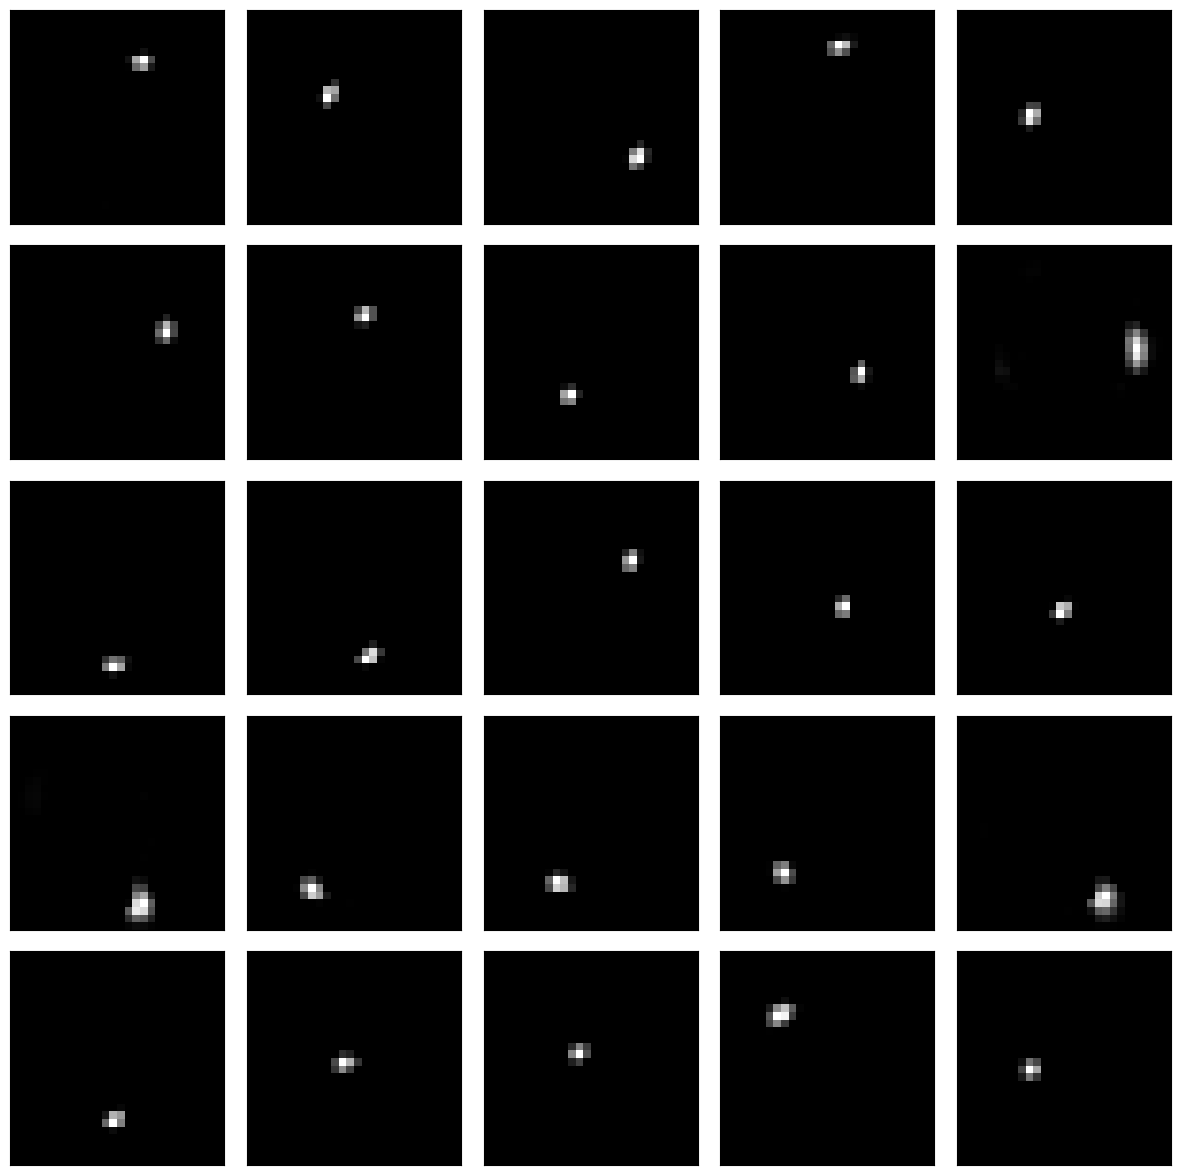

In [108]:

# Since components are not reshaped to the original image dimensions, they are displayed as is
logging.info("Visualizing NMF components")
plot_nmf_components(components, image_size, latent_size)



2024-05-14 07:59:52,234 - INFO - Predicting and visualizing denoised images
2024-05-14 07:59:52,243 - INFO - Predicting
2024-05-14 07:59:52,244 - INFO - Creating features and adding noise
2024-05-14 07:59:52,245 - INFO - Creating interaction terms


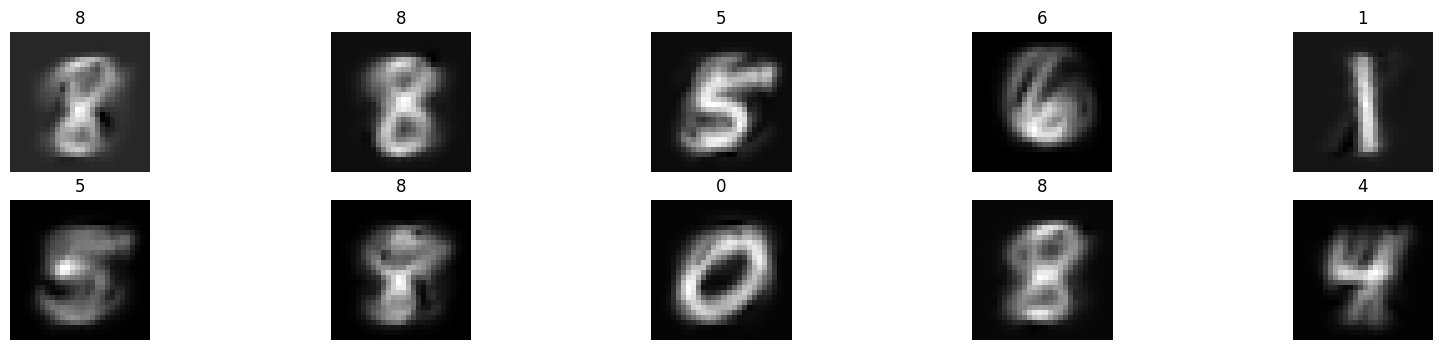

In [176]:

# Predict and visualize denoised images
logging.info("Predicting and visualizing denoised images")
#randomly select a number between 0 and 9 to predict the image
test_labels = np.random.choice(train_labels, 10)
predicted_images = predict(model, fitted_image_encoder, fitted_text_encoder, test_labels, seed=137, image_size=image_size)
plot_images(predicted_images, test_labels, n=10)


# NMF Deep Dive

2024-05-13 22:32:38,281 - INFO - Visualizing Basis and Coefficients Matrices


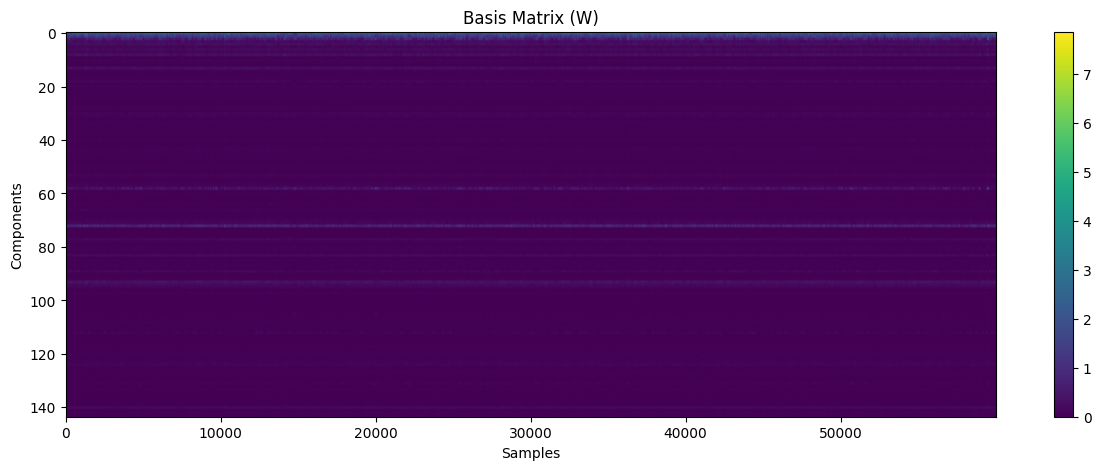

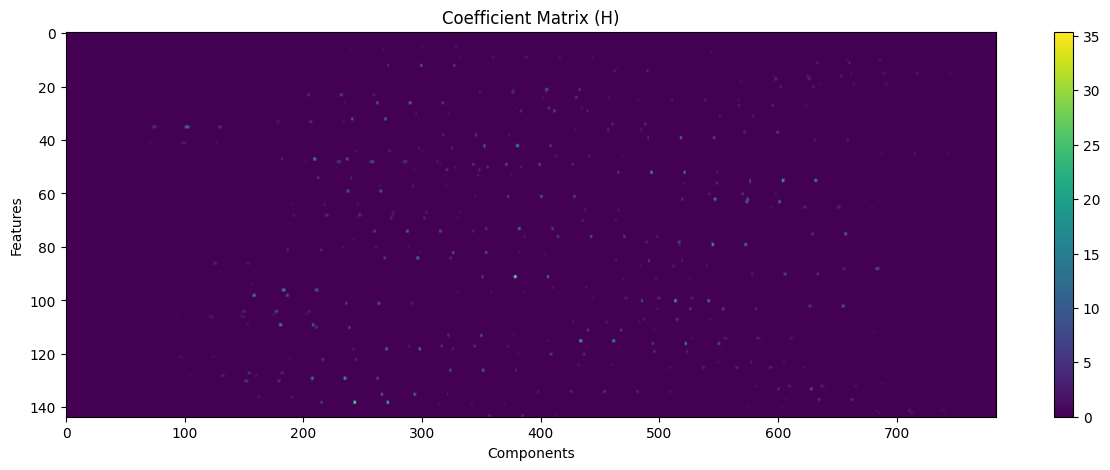

2024-05-13 22:32:39,645 - INFO - Reconstructing images and comparing with original images


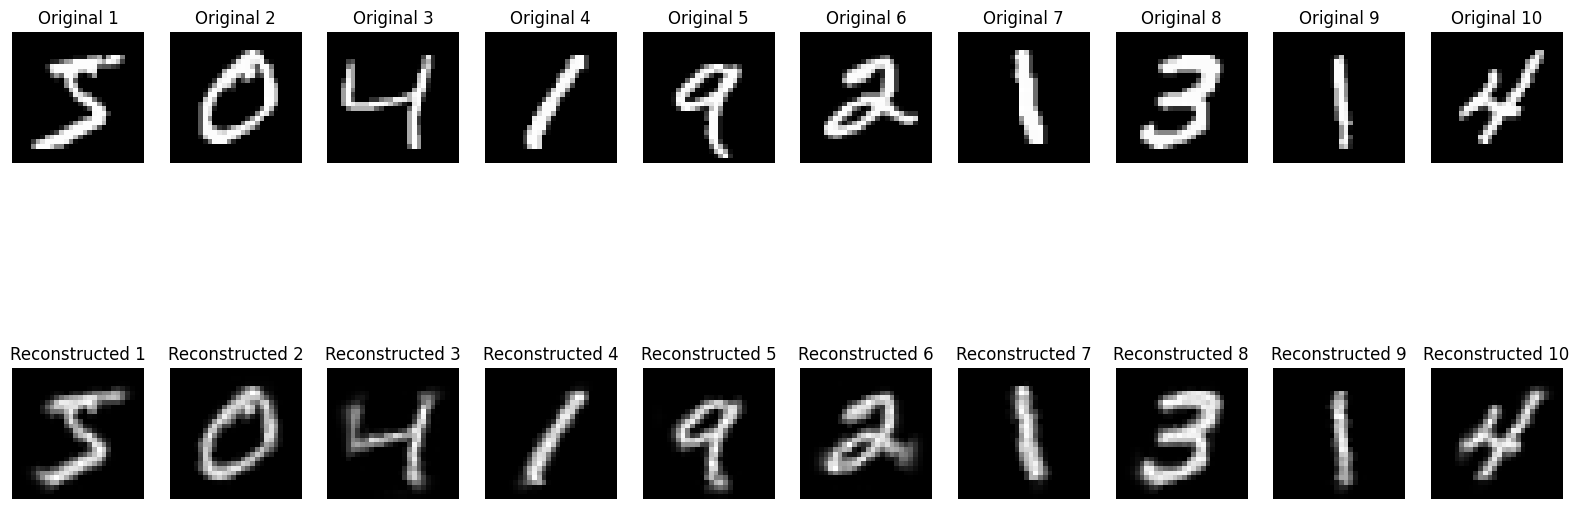

2024-05-13 22:32:40,872 - INFO - Visualizing sampled coefficients


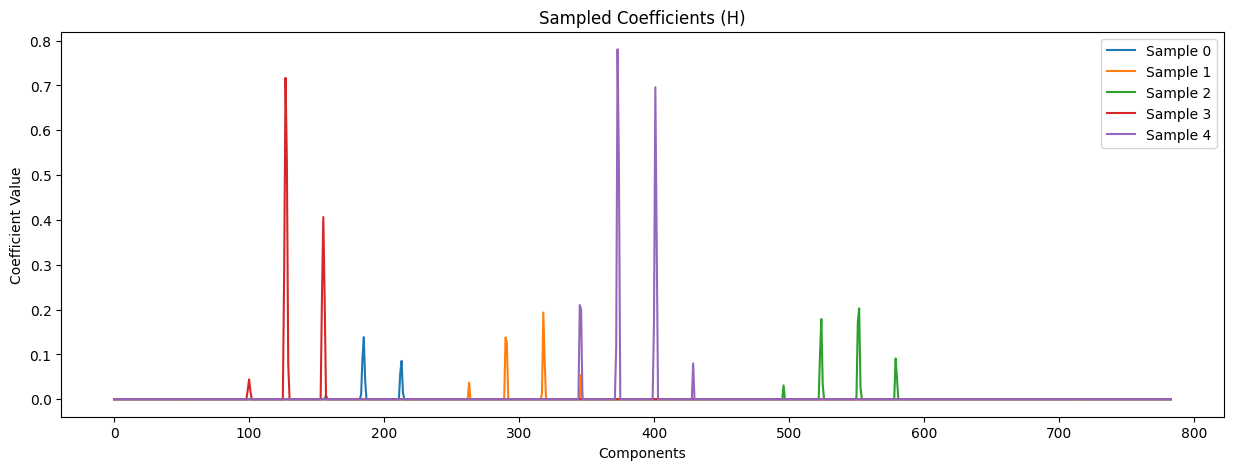

In [95]:

def plot_reconstructed_images(original_images, reconstructed_images, image_size, n=10):
    """
    Plot the original and reconstructed images side by side for comparison.
    
    Args:
        original_images (ndarray): The original images.
        reconstructed_images (ndarray): The reconstructed images.
        image_size (int): The size of the images (assumed to be square).
        n (int): Number of images to plot.
    """
    plt.figure(figsize=(20, 8))
    for i in range(n):
        # Original images
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original_images[i].reshape(image_size, image_size), cmap='gray')
        plt.title(f"Original {i+1}")
        plt.axis('off')
        
        # Reconstructed images
        ax = plt.subplot(2, n, i + n + 1)
        plt.imshow(reconstructed_images[i].reshape(image_size, image_size), cmap='gray')
        plt.title(f"Reconstructed {i+1}")
        plt.axis('off')
    plt.show()
    
def plot_basis_and_coefficients(W, H, image_size, latent_size):
    """
    Plot the basis (W) and coefficient (H) matrices of the NMF model.
    
    Args:
        W (ndarray): The basis matrix from NMF.
        H (ndarray): The coefficient matrix from NMF.
        image_size (int): The size of the images (assumed to be square).
        latent_size (int): The size of the latent space.
    """
    # Plot the basis matrix W as feature vectors
    plt.figure(figsize=(15, 5))
    plt.title('Basis Matrix (W)')
    plt.imshow(W.T, aspect='auto', cmap='viridis')
    plt.colorbar()
    plt.xlabel('Samples')
    plt.ylabel('Components')
    plt.show()

    # Plot the coefficient matrix H
    plt.figure(figsize=(15, 5))
    plt.title('Coefficient Matrix (H)')
    plt.imshow(H, aspect='auto', cmap='viridis')
    plt.colorbar()
    plt.xlabel('Components')
    plt.ylabel('Features')
    plt.show()


def plot_sampled_coefficients(H, sample_indices):
    """
    Plot sampled rows from the coefficient matrix (H) to visualize which features are most important.
    
    Args:
        H (ndarray): The coefficient matrix from NMF.
        sample_indices (list): List of indices to sample from H.
    """
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(sample_indices):
        plt.plot(H[idx], label=f'Sample {idx}')
    plt.title('Sampled Coefficients (H)')
    plt.xlabel('Components')
    plt.ylabel('Coefficient Value')
    plt.legend()
    plt.show()

nmf_model = image_encoder.named_steps['NMF']
W = nmf_model.transform(image_encoder.named_steps['scaler'].transform(train_X.reshape(train_X.shape[0], image_size**2)))
H = nmf_model.components_

logging.info("Visualizing Basis and Coefficients Matrices")
plot_basis_and_coefficients(W, H, image_size, latent_size)

logging.info("Reconstructing images and comparing with original images")
reconstructed_images = W.dot(H).reshape(train_X.shape) # this 
plot_reconstructed_images(train_X, reconstructed_images, image_size)

logging.info("Visualizing sampled coefficients")
sample_indices = [0, 1, 2, 3, 4]
plot_sampled_coefficients(H, sample_indices)


In [96]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming W (components matrix from NMF) and H (coefficient matrix) are available
components = image_encoder.named_steps['NMF'].components_

W = components  # Make sure this is (144, 784)
H = model.coef_  # Your NMF model's coefficients
# Select a specific image and its coefficients
sample_index = 0  # Change this index to analyze different samples
original_image = train_X[indices_of_1[sample_index]].reshape(28, 28)  # Reshape if needed
sample_coefficients = coefficients_for_1[sample_index, :]

# Check dimensions
print("W shape:", W.shape)
print("sample_coefficients shape:", sample_coefficients.shape)

# Reconstruct the image from NMF components
reconstructed_image = np.dot(sample_coefficients, W).reshape(28, 28)

# Identify top components
top_components = np.argsort(sample_coefficients)[-5:]  # Get indices of top 5 components

# Plotting
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

# Original image
axes[0].imshow(original_image, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

# Reconstructed image
axes[1].imshow(reconstructed_image, cmap='gray')
axes[1].set_title('Reconstructed Image')
axes[1].axis('off')

# Coefficients heatmap
sns.heatmap(sample_coefficients.reshape(1, -1), ax=axes[2], cmap='viridis', cbar=True)
axes[2].set_title('Coefficients Heatmap')
axes[2].set_xlabel('Components')
axes[2].set_yticklabels([])

# Top component images
for i, comp_idx in enumerate(top_components):
    component_image = W[comp_idx].reshape(28, 28)  # Reshape component to image dimensions
    axes[i+3].imshow(component_image, cmap='gray')
    axes[i+3].set_title(f'Component {comp_idx+1}')
    axes[i+3].axis('off')

plt.tight_layout()
plt.show()


W shape: (144, 784)
sample_coefficients shape: (784,)


ValueError: shapes (784,) and (144,784) not aligned: 784 (dim 0) != 144 (dim 0)

In [48]:

# Predict and visualize
logging.info("Making predictions")
predicted_images = predict(model, fitted_image_encoder, fitted_text_encoder, train_labels[:10], image_size=image_size)
logging.info("Predicted images")
plot_images(predicted_images, train_labels[:10], n=10)


2024-05-11 18:26:27,219 - INFO - Making predictions
2024-05-11 18:26:27,220 - INFO - Predicting
2024-05-11 18:26:27,221 - INFO - Creating features and adding noise


AttributeError: 'NoneType' object has no attribute 'shape'